# CIFAR-10 チュートリアル[付録]

ここでは本論で言及できなかった点について幾つかまとめてみます。

## 付録A: データの保存&読み込み

### A.1 損失関数, 精度

ここまでは一つのコードで学習の実行&グラフの表示をしてきましたが、学習結果を保存し、後から読み込んでグラフを表示することができます。コレを見るために上のコードを以下のように書き換えてみます。(後半のグラフ等の出力をカットしました。)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dlipr
import os

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout, Activation, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.callbacks import CSVLogger

# ---------------------------------------------------------
# Load and preprocess data
# ---------------------------------------------------------
data = dlipr.cifar.load_cifar10()

# plot some example images
dlipr.utils.plot_examples(data, fname='examples.png')

# preprocess the data in a suitable way
# reshape the image matrices to vectors
#RGB 255 = white, 0 = black
X_train = data.train_images.reshape([-1, 32, 32, 3])
X_test = data.test_images.reshape([-1, 32, 32, 3])
print('%i training samples' % X_train.shape[0])
print('%i test samples' % X_test.shape[0])
print(X_train.shape)

# convert integer RGB values (0-255) to float values (0-1)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# convert class labels to one-hot encodings
Y_train = to_categorical(data.train_labels, 10)
Y_test = to_categorical(data.test_labels, 10)

# ----------------------------------------------------------
# Model and training
# ----------------------------------------------------------


num_classes = 10

# model
model = Sequential()

# CNN layer 1
model.add(Convolution2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CNN layer 2
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# output
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

model.compile(
loss='categorical_crossentropy',
optimizer=Adam(lr=0.001),
metrics=['accuracy'])

# see callbacks
fit = model.fit(X_train, Y_train,
              batch_size=128,
              epochs=40, #shouldn't be raised to 100, because the overfitting occurs.
              verbose=2,
              validation_split=0.1,
              callbacks=[CSVLogger('history.csv')])

ここで保存された`history.csv`を利用して、先程のグラフを表示させてみると、

これを実行すると、`history.csv`ファイルが保存されます。このファイルには
```
epoch,acc,loss,val_acc,val_loss
0,0.38851111114819842,1.660481661966112,0.51759999999999995,1.3262438331604003
1,0.54308888895246721,1.2750055780834622,0.60319999999999996,1.1193507038116455
2,0.6129777777353923,1.0916920099788241,0.68000000000000005,0.92864536266326903
3,0.65393333343929716,0.97272546102735735,0.71540000000000004,0.82300713539123538
4,0.68602222224341503,0.89219131661521067,0.73939999999999995,0.76103409023284907
```
のように、`acc`, `loss`, `val_acc`, `val_loss`がそれぞれ保存されています(具体的な値は実行環境による)。これを読み出せばグラフにすることができますね。実際以下のようにすれば、可視化できます:
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

d = np.genfromtxt('history.csv', delimiter=',', names=True)
fig, ax = plt.subplots(1)
ax.plot(d['epoch'], d['acc'], c='k')
ax.plot(d['epoch'], d['val_acc'], c='r')
ax.legend(('Train', 'Validation'))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
fig.savefig('history.png')

<img src='appendix_results/history.png'/>

となり、ちゃんとグラフが保存されたことがわかります。

本論で用いた`model.save('results/my_model.h5')`はモデル全体を保存するもので、後から学習結果を使うことができます。一方、`history.csv`には学習結果しか保存されていないので、その点の違いに注意しなければなりません。

特に`model.save`を使えば、学習させた後の重み等も保存することができます。このようにすれば、後からその結果を使うことが分かっている場合は、GPUでヘビーな計算をさせてモデルを保存しておけば、自前のコンピュータ上で負担をかけずにその結果を利用することができます。

### A.2 テストデータのチェック

本論ではdliprパッケージを用いてテストデータとの比較、その分類の精度についてまとめました。以前dliprを使わなくても簡単にテストデータで正しく分類できるか試せるか知りたいという質問を頂いたので、ここではdliprパッケージを用いなくてもできる簡単な方法をまとめておきます。

まず`model = load_model('my_model.h5')`をCIFAR-10のソースコード (ここで扱ったものでなくても構いません) に追加して実行します。このあと`my_model.h5`というファイルが同じディレクトリに保存されるかと思います。その後以下を実行すると、テストデータの画像に対する分類の結果やその精度が得られます。

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


50000 training samples
10000 test samples
(50000, 32, 32, 3)
☆テスト画像: cat


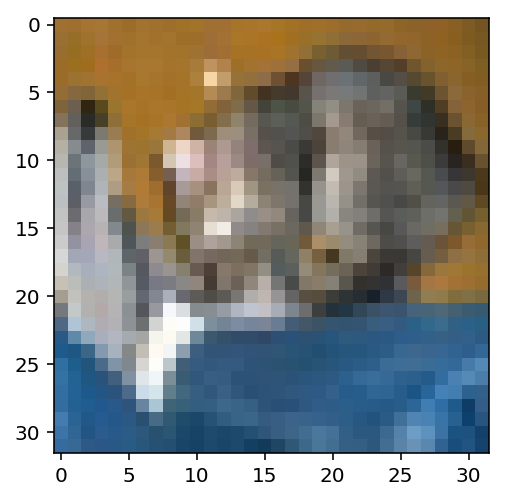

0 - 分類されたものはcatです。精度は89.85%です。

################################################
☆テスト画像: ship


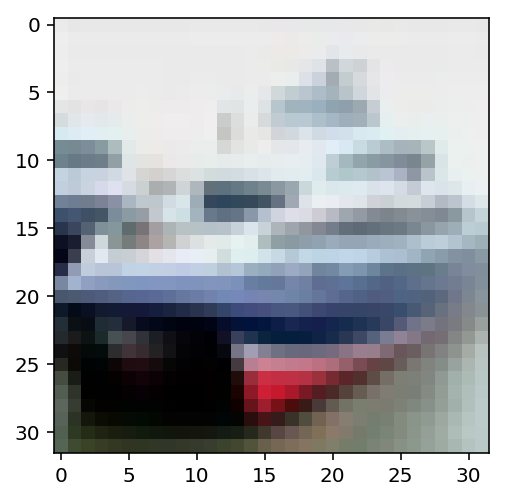

1 - 分類されたものはshipです。精度は65.78%です。

################################################
☆テスト画像: ship


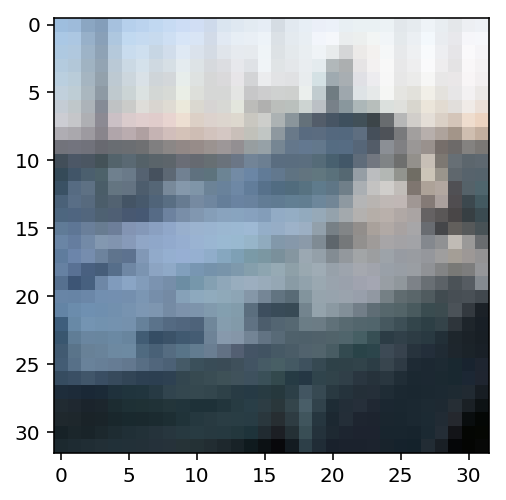

2 - 分類されたものはshipです。精度は72.99%です。

################################################
☆テスト画像: airplane


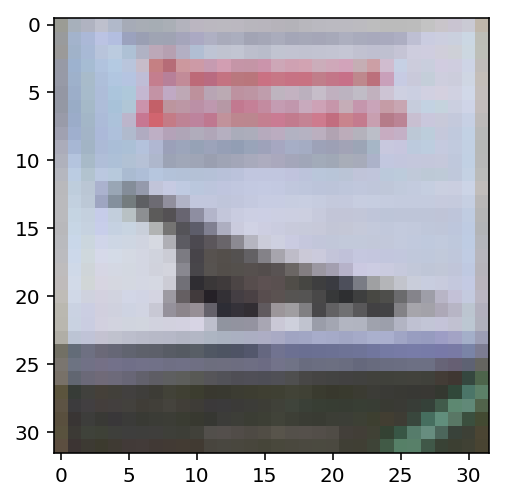

3 - 分類されたものはairplaneです。精度は98.34%です。

################################################
☆テスト画像: frog


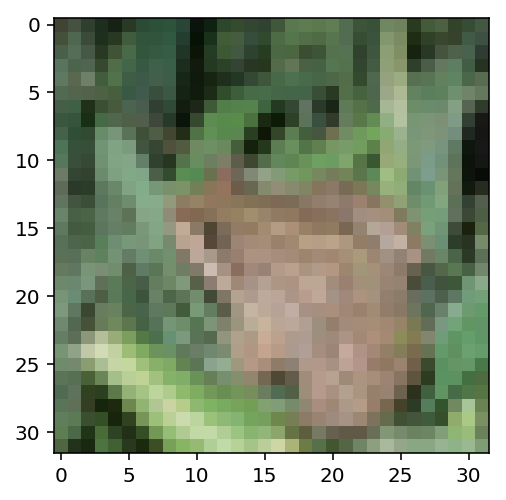

4 - 分類されたものはfrogです。精度は94.25%です。

################################################


In [2]:
from keras.datasets import cifar10
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.np_utils import to_categorical
import numpy as np
import os
import matplotlib.pyplot as plt


def plot_image(X, label=None):
    print('☆テスト画像: %s' % label)
    plt.imshow(X)
    plt.show()
    plt.clf()

if __name__=='__main__':
    ## import data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    X_train = X_train.reshape([-1, 32, 32, 3])
    X_test = X_test.reshape([-1, 32, 32, 3])
    print('%i training samples' % X_train.shape[0])
    print('%i test samples' % X_test.shape[0])
    print(X_train.shape)

    # convert integer RGB values (0-255) to float values (0-1)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255

    ## CIFAR-10公式ラベル
    cifar10_labels = np.array([
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'])

    # load model
    model = load_model(os.path.join('results', 'my_model.h5')) # 保存したモデルから読み込む

    # output
    preds = model.predict(X_test) # modelは学習させたもの
    category = np.argmax(preds, axis=1)
    for i in range(5):
        classed = category[i]
        labels = cifar10_labels[classed]
        plot_image(X_test[i], labels)
        print('{0} - 分類されたものは{1}です。精度は{2:.2f}%です。\n' .format(i, labels, preds[i][classed]*100))
        print("################################################")

### A.3 任意の画像でチェック

ネットで拾ってきたような任意の画像でチェックしたいときは、以下のようにすればできます。ここでは
<img src='car.png'/>
from いらすとや

を使います。

In [3]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import os

# CIFAR-10公式ラベル
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

model = load_model(os.path.join('results','my_model.h5')) # 保存したモデルから読み込む
img_path = 'images/car.png' # 任意の画像
img = image.load_img(img_path, target_size=(32, 32)) #入力画像のサイズ
x = image.img_to_array(img) # 画像データをnumpy.arrayへ変換
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x) # modelは学習させたもの
category = np.argmax(preds, axis=1)

classed = category[0]

print('分類されたものは{0}です。' .format(cifar10_labels[classed]))

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
分類されたものはtruckです。


と得られます。この場合は精度が出ないんですね。。出せないのか、出ないコード(or 方法)なのかわかりません。

この方法はImageNet等のpretrainedモデルを使うとより幅広いカテゴリー分けができます。以下参照ください: [Applications on Keras](https://keras.io/ja/applications/)

## 付録B: Tensorboard出力

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dlipr
import os

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout, Activation, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.callbacks import CSVLogger

# ---------------------------------------------------------
# Load and preprocess data
# ---------------------------------------------------------
data = dlipr.cifar.load_cifar10()

# plot some example images
dlipr.utils.plot_examples(data, fname='examples.png')
print(data.train_images.shape)
print(data.train_labels.shape)
print(data.test_images.shape)
print(data.test_labels.shape)

# preprocess the data in a suitable way
# reshape the image matrices to vectors
#RGB 255 = white, 0 = black
X_train = data.train_images.reshape([-1, 32, 32, 3])
X_test = data.test_images.reshape([-1, 32, 32, 3])
print('%i training samples' % X_train.shape[0])
print('%i test samples' % X_test.shape[0])
print(X_train.shape)

# convert integer RGB values (0-255) to float values (0-1)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# convert class labels to one-hot encodings
Y_train = to_categorical(data.train_labels, 10)
Y_test = to_categorical(data.test_labels, 10)

# ----------------------------------------------------------
# Model and training
# ----------------------------------------------------------


num_classes = 10

# model
model = Sequential()

model.add(Convolution2D(
            32, 
            kernel_size=(3, 3), 
            padding='same',
            input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Convolution2D(
            32, 
            kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(
            (2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(
            64, 
            kernel_size=(3, 3), 
            padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(
            64, 
            kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

model.compile(
loss='categorical_crossentropy',
optimizer=Adam(lr=0.001),
metrics=['accuracy'])

tb = keras.callbacks.TensorBoard(
        log_dir='appendix_results/cifar10_tb', 
        histogram_freq=5, 
        write_graph=True, 
        write_images=False)

fit = model.fit(X_train, Y_train,
              batch_size=128,
              epochs=40, #shouldn't be raised to 100, because the overfitting occurs.
              verbose=2,
              validation_split=0.1,
              callbacks=[tb])

コレを実行すれば、`cifar10_tb/`以下にTensorboardのファイルができるので、`tensorboard --logdir=cifar10_tb/`とコマンドを打てば、ブラウザから以下のように読み取れるはずです。

<img src='appendix_results/acc_tb.png'/>
<img src='appendix_results/loss_tb.png'/>
<img src='appendix_results/val_acc_tb.png'/>
<img src='appendix_results/val_loss_tb.png'/>